# MNIST with RNN

We create a RNN based classifier for the MNIST dataset. 
Basic Idea:
* Each image in the MNIST dataset: 28x28.
* Treat each row of every image as a time-step.
* Then at each time-step we input one row of the image to the RNN. That is, input to the RNN at each time step has shape (1,28)
* Pass last output to a single Fully Connected layer -> softmax on the output of the FCN -> Cross-Entropy.

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

In [0]:
#load the dataset into the mnist variable. Labels: Onehot encoded
mnist = input_data.read_data_sets('/tmp/data/',one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
#lets define some variables
num_classes = 10
time_steps = 28 #how many times should the RNN cell be unrolled
batch_size = 128
num_hidden_units = 128 #128 neurons in each RNN cell. Then W_x.shape = [d,num_hidden_units]
dims = 28 #dimension of each vector. 
num_epochs = 5
val_size = 1024
test_size = 2048


## mnistRNN Class

In this class, we design the compute graph for the MNIST RNN classifier.

Let,  $X \in \mathbb{R}^{N,D}$, the RNN has hidden unit $W_X \in \mathbb{R}^K$. Then,

$h_t = tanh(XW_X +h_{t-1}W_h) $, where,

$h \in \mathbb{R}^{N,K}$ and $W_h \in \mathbb{R}^{K,K}$

In [0]:
#Here we create our Neural Network class.

class mnistRNN:
  
  def __init__(self, name):
    self.name = name
    
    
  
  def build(self):
    '''
      We create the compute graph for our RNN here.
    '''
    
    def rnn_cell(previous_state, x):
      '''
        Represents one RNN Cell. 
        
        Inputs
        ------
        previous_state: the previous cell's hidden state.
        x: current time stamp's input.
        
        Returns
        -------
        current_state: the state of the current cell.
      '''
      
      current_state = tf.nn.tanh(tf.matmul(previous_state,self.Wh) + tf.matmul(x,self.Wx) + self.b)
      return current_state
    
    def linear_op(op):
      return tf.matmul(op,self.Wo) + self.bo
    
    
    #placeholders for the data.
    self.X = tf.placeholder(tf.float32,name='inputs', shape=[None,time_steps,dims])
    self.Y = tf.placeholder(tf.float32, name='labels',shape=[None,num_classes])
    
    #Open variable scope, define our model.
    with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
      
      with tf.name_scope('rnn_weights'):
        self.Wx = tf.get_variable(name='W_x',dtype=tf.float32, shape=[dims,num_hidden_units])

        self.b = tf.get_variable(name='b', dtype = tf.float32, shape=[num_hidden_units],initializer=tf.zeros_initializer())

        self.Wh = tf.get_variable(name='W_h',dtype=tf.float32, shape=[num_hidden_units,num_hidden_units])
        
        # Wo, bo are the Weights and biases for the linear transformation of the outputs.
        self.Wo = tf.get_variable(name='W_o',dtype=tf.float32, shape=[num_hidden_units, num_classes])
        self.bo = tf.get_variable(name='b_o', dtype = tf.float32, shape=[num_classes],initializer=tf.zeros_initializer())
      
        #Now, we reshape the input from [batch_size, time_steps, dims] to [time_steps,batch_size,dims]. 
        #We do this so that we can iterate over each time step and call rnn_cell for each time step as it should be called.
        # This reshaping is done using the tf.transpose() function.
        
        #X.shape = [batch_size,time_steps,dims]
        _X = tf.transpose(self.X, [1,0,2])
        #new X.shape = [time_steps,batch_size,dims]
        
        # Initial State --> h_{0}. It is of the same shape as h. We initialize initial_state to 0.
        self.initial_state = tf.placeholder(name='initial_state',dtype=tf.float32,shape=[self.X.shape[0],num_hidden_units])
        #self.initial_state = tf.zeros((batch_size,num_hidden_units))
        
        '''
          now we apply rnn_cell repeatedly over all the time steps. 
          tf.scan(func, elem, initializer, name):
            func: the function to be called.
            elem: the first parameter of the function func.
            initializer: initial value
            name: name
            
        '''
        self.outputs = tf.scan(rnn_cell,_X,initializer = self.initial_state, name='states')
        
        #now we apply a linear transformation to the output of the last time step. 
        #Here we use only the output of the last time step for the classification.
        
        self.last_state = self.outputs[-1]
        
        self.ops = tf.map_fn(linear_op,self.outputs)
        
        self.logits = self.ops[-1]
        
        #We apply softmax to the logits. This will be used to make predictions.
        self.softmax = tf.nn.softmax(self.logits)
        
        #Now we calculate the loss. We use cross entropy loss. 
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = self.Y, logits = self.logits))
        
        #now we calculate accuracy of the model
        correct_predictions = tf.equal(tf.argmax(self.Y,axis=1),tf.argmax(self.softmax,axis=1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))
        
        #Next we should train the model --> Gradient Descent!
        #We use the Adam Optimizer with default Learning Rate(1e-2)
        
        self.optimizer = tf.train.AdagradOptimizer(5e-2)
        self.opt_step = self.optimizer.minimize(self.loss)
        
        

  def train(self):
    '''
      Here we train the RNN. 
      Learning Rate, Batch Size, num_hidden_units are all hyperparameters which can be pased as arguements for this functions.
      This can be used for Hyperparameter tuning. We don't do it here. So we don't take any argurments.
    '''
    def print_step(msg,it, loss, acc):
      
      if it == -1:
        pre = 'Initial '
      else:
        pre = f'Iteration {it} '
       
      print(pre+msg+f' Loss: {loss:.3f}, {msg} Acc: {acc:.3f}')
     
      return
      
    
    
    self.session = tf.Session()
    
    s = self.session
    
    #We declare some lists to keep track of our progress
    train_losses=[]
    train_accs = []
    val_losses = []
    val_accs = []
    
    
    
    with s.as_default():
      
      s.run(tf.global_variables_initializer())
      
      #For Validation set, we use 1024 samples
      X_val,Y_val = mnist.validation.next_batch(val_size)
      X_val = X_val.reshape((-1,time_steps,dims))
      
      # number of batches = number of examples / batch size
      num_batches = mnist.train.num_examples // batch_size
      
      #first train batch
      X_batch,Y_batch = mnist.train.next_batch(batch_size)
      X_batch = X_batch.reshape((batch_size,time_steps,dims))
      
      #Initial train and val loss, acc
      
      
      state_val = np.zeros((val_size,num_hidden_units))
      state_train = np.zeros((batch_size,num_hidden_units))
      
      train_loss, train_acc,state_train = s.run((self.loss,self.accuracy,self.last_state), feed_dict={self.X:X_batch, self.Y:Y_batch,self.initial_state:state_train})
      val_loss, val_acc, state_val = s.run((self.loss,self.accuracy, self.last_state), feed_dict={self.X:X_val, self.Y:Y_val,self.initial_state:state_val})
      
      train_losses += [train_loss]
      train_accs += [train_acc]
      
      val_losses += [val_loss]
      val_accs += [val_acc]
      
      print_step('Train',-1, train_loss, train_acc)
      print_step('Val',-1, val_loss, val_acc)
      print
      
      # We train here.
      for epoch in range(num_epochs):
        print(f'Epoch {epoch}')
        for itr in range(num_batches):
          state_val = np.zeros((val_size,num_hidden_units))
          state_train = np.zeros((batch_size,num_hidden_units))
          X_batch,Y_batch = mnist.train.next_batch(batch_size)
          X_batch = X_batch.reshape((-1,time_steps,dims))
          train_loss, train_acc,state_train_,_ = s.run((self.loss,self.accuracy,self.last_state,self.opt_step), feed_dict={self.X:X_batch, self.Y:Y_batch,self.initial_state:state_train})
          val_loss, val_acc, state_val_ = s.run((self.loss,self.accuracy, self.last_state), feed_dict={self.X:X_val, self.Y:Y_val,self.initial_state:state_val})
          
          train_losses += [train_loss]
          train_accs += [train_acc]
      
          val_losses += [val_loss]
          val_accs += [val_acc]
          
          if itr % 200 == 0:
            print_step('Train', itr, train_loss, train_acc)
            print_step('Val',itr, val_loss, val_acc)
            print(f'state_train_sum: {np.sum(state_train):.3f}, state_val_sum:{np.sum(state_val):.3f}\n')
      
      #self.test()
    self.history={
        'train_losses':train_losses,
        'train_accuracies':train_accs,
        'val_losses':val_losses,
        'val_accuracies': val_accs
    }
    
    
    
    return
            
      
  def test(self):
    
    #We test out on 2048 test images
    X_test, Y_test = mnist.test.next_batch(test_size)
    X_test = X_test.reshape((-1,time_steps,dims))
    print(X_test.shape)
    
    initial_state_test = np.zeros((test_size, num_hidden_units))
    
    s = self.session
    

    test_loss, test_acc,_ = s.run((self.loss,self.accuracy,self.last_state), feed_dict={self.X:X_test, self.Y:Y_test, self.initial_state:initial_state_test})

    print(f'TEST LOSS: {test_loss:.3f}, TEST ACCURACY:{test_acc:.3f}')
      
    return
        
      

In [0]:
#We create object for mnistRNN, call build, train and test functions.

mrnn = mnistRNN('MNIST_RNN')
mrnn.build()

In [0]:
mrnn.train()

Initial Train Loss: 2.344, Train Acc: 0.125
Initial Val Loss: 2.329, Val Acc: 0.154
Epoch 0
Iteration 0 Train Loss: 2.354, Train Acc: 0.156
Iteration 0 Val Loss: 2.202, Val Acc: 0.222
state_train_sum: 0.000, state_val_sum:0.000

Iteration 200 Train Loss: 0.910, Train Acc: 0.695
Iteration 200 Val Loss: 0.810, Val Acc: 0.722
state_train_sum: 0.000, state_val_sum:0.000

Iteration 400 Train Loss: 0.405, Train Acc: 0.891
Iteration 400 Val Loss: 0.388, Val Acc: 0.896
state_train_sum: 0.000, state_val_sum:0.000

Epoch 1
Iteration 0 Train Loss: 0.448, Train Acc: 0.875
Iteration 0 Val Loss: 0.376, Val Acc: 0.888
state_train_sum: 0.000, state_val_sum:0.000

Iteration 200 Train Loss: 0.312, Train Acc: 0.922
Iteration 200 Val Loss: 0.241, Val Acc: 0.943
state_train_sum: 0.000, state_val_sum:0.000

Iteration 400 Train Loss: 0.234, Train Acc: 0.930
Iteration 400 Val Loss: 0.210, Val Acc: 0.950
state_train_sum: 0.000, state_val_sum:0.000

Epoch 2
Iteration 0 Train Loss: 0.217, Train Acc: 0.953
Iterat

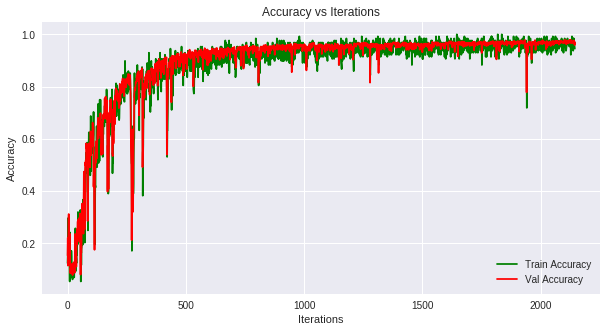

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.title('Accuracy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.plot(mrnn.history['train_accuracies'],color='green',label='Train Accuracy')
plt.plot(mrnn.history['val_accuracies'],color='red', label='Val Accuracy')
plt.legend()

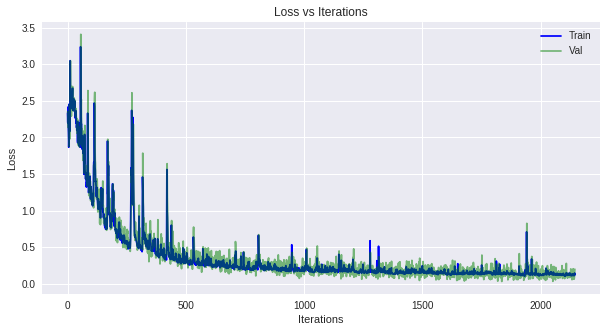

In [0]:

plt.figure(figsize=(10,5))

plt.title('Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss'),

plt.plot(mrnn.history['val_losses'],color='blue',label='Train')
plt.plot(mrnn.history['train_losses'],color='green', alpha=0.5,label='Val')
plt.legend()

In [0]:
mrnn.test()

(2048, 28, 28)
TEST LOSS: 0.131, TEST ACCURACY:0.962


## Done.

We see taht after traning for 5 epochs, we achieve a test accuracy of 96.2% which is considerably better than the CNN model for MNIST classification.